# ***1) Setup and Data Loading***



In [49]:
# import os

# # Try importing Google Colab-specific functions
# try:
#     from google.colab import files
#     colab_available = True
# except ImportError:
#     colab_available = False

# # -------------------- 1. Handle Directory Selection (Google Colab or Manual Entry) -------------------- #
# if colab_available:
#     print("Running in Google Colab. Please upload your MNIST dataset ZIP file if not already extracted.")
#     uploaded = files.upload()  # Google Colab manual upload (only if needed)
#     dataset_dir = list(uploaded.keys())[0]  # Assume the uploaded file is a folder or ZIP
#     dataset_dir = os.path.splitext(dataset_dir)[0]  # Remove extension if uploaded
# else:
#     dataset_dir = input("Enter the full path to the extracted MNIST dataset directory: ").strip()  # Manual input for local execution

# # -------------------- 2. Verify Directory Exists -------------------- #
# if not os.path.exists(dataset_dir):
#     print(f"Error: Directory '{dataset_dir}' not found. Please check the path and try again.")
#     exit()

# # -------------------- 3. Access Files from Directory -------------------- #
# train_images_path = os.path.join(dataset_dir, "train-images.idx3-ubyte")
# train_labels_path = os.path.join(dataset_dir, "train-labels.idx1-ubyte")
# test_images_path  = os.path.join(dataset_dir, "t10k-images.idx3-ubyte")
# test_labels_path  = os.path.join(dataset_dir, "t10k-labels.idx1-ubyte")

# # -------------------- 4. Verify That Files Exist -------------------- #
# required_files = [train_images_path, train_labels_path, test_images_path, test_labels_path]
# missing_files = [file for file in required_files if not os.path.exists(file)]

# if missing_files:
#     print("Error: The following required files are missing:")
#     for file in missing_files:
#         print(f" - {file}")
#     exit()

# print("All required dataset files found. Ready for processing.")


# ***Data Preprocessing***

In [50]:
import struct
import numpy as np

# -------------------- 1. Load IDX Dataset -------------------- #
def load_idx_images(file_path):
    """Reads an IDX3-ubyte file and returns a NumPy array of shape (num_images, 28, 28)."""
    with open(file_path, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.fromfile(f, dtype=np.uint8).reshape(num_images, rows, cols)
        return data

def load_idx_labels(file_path):
    """Reads an IDX1-ubyte file and returns a NumPy array of shape (num_labels,)."""
    with open(file_path, 'rb') as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

# Load dataset using correct filenames
train_images = load_idx_images('train-images.idx3-ubyte')
train_labels = load_idx_labels('train-labels.idx1-ubyte')
test_images  = load_idx_images('t10k-images.idx3-ubyte')
test_labels  = load_idx_labels('t10k-labels.idx1-ubyte')

print("Train images shape:", train_images.shape)  # (60000, 28, 28)
print("Train labels shape:", train_labels.shape)  # (60000,)
print("Test images shape: ", test_images.shape)   # (10000, 28, 28)
print("Test labels shape: ", test_labels.shape)   # (10000,)

# -------------------- 2. Filter Digits 0, 1, 2 -------------------- #
def filter_classes(images, labels, keep_classes=[0,1,2]):
    """Filters dataset to keep only the specified digit classes."""
    mask = np.isin(labels, keep_classes)
    return images[mask], labels[mask]

# Apply filtering
train_images_filtered, train_labels_filtered = filter_classes(train_images, train_labels, [0,1,2])
test_images_filtered, test_labels_filtered   = filter_classes(test_images, test_labels, [0,1,2])

print("Filtered train images shape:", train_images_filtered.shape)
print("Filtered train labels shape:", train_labels_filtered.shape)
print("Filtered test images shape: ", test_images_filtered.shape)
print("Filtered test labels shape: ", test_labels_filtered.shape)

# -------------------- 3. Random Sampling of 100 Samples Per Class -------------------- #
def random_sample_per_class(images, labels, n=100, classes=[0,1,2]):
    """Randomly selects 'n' samples per class without a fixed seed."""
    selected_images = []
    selected_labels = []
    
    for digit in classes:
        indices = np.where(labels == digit)[0]  # Get indices of the class
        chosen_indices = np.random.choice(indices, size=n, replace=False)  # Randomly select samples
        selected_images.append(images[chosen_indices])
        selected_labels.append(labels[chosen_indices])
    
    return np.concatenate(selected_images, axis=0), np.concatenate(selected_labels, axis=0)

# Apply random sampling (without fixed seed)
train_images_final, train_labels_final = random_sample_per_class(train_images_filtered, train_labels_filtered, n=100)
test_images_final,  test_labels_final  = random_sample_per_class(test_images_filtered, test_labels_filtered, n=100)

print("Final train images shape:", train_images_final.shape)  # (300, 28, 28)
print("Final train labels shape:", train_labels_final.shape)  # (300,)
print("Final test images shape: ", test_images_final.shape)   # (300, 28, 28)
print("Final test labels shape: ", test_labels_final.shape)   # (300,)

# -------------------- 4. Flatten and Normalize Data -------------------- #
train_X = train_images_final.reshape(300, -1) / 255.0  # Convert (28,28) to (784,)
test_X  = test_images_final.reshape(300, -1) / 255.0  

train_y = train_labels_final  # Labels remain unchanged
test_y  = test_labels_final   

print("train_X shape:", train_X.shape, "test_X shape:", test_X.shape)
print("train_y shape:", train_y.shape, "test_y shape:", test_y.shape)


Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape:  (10000, 28, 28)
Test labels shape:  (10000,)
Filtered train images shape: (18623, 28, 28)
Filtered train labels shape: (18623,)
Filtered test images shape:  (3147, 28, 28)
Filtered test labels shape:  (3147,)
Final train images shape: (300, 28, 28)
Final train labels shape: (300,)
Final test images shape:  (300, 28, 28)
Final test labels shape:  (300,)
train_X shape: (300, 784) test_X shape: (300, 784)
train_y shape: (300,) test_y shape: (300,)


# ***2. Compute MLE Estimates [1]***

In [51]:
import numpy as np

# Get the unique digit classes (0,1,2)
classes = np.unique(train_y)

# Dictionaries to store mean and covariance for each class
means = {}
covariances = {}

for c in classes:
    # Get all samples belonging to class c
    X_c = train_X[train_y == c]  # Shape (100, 784) for each class

    # Compute the MLE estimate of mean (μc) - Mean vector of shape (784,)
    mu_c = np.mean(X_c, axis=0)

    # Compute the MLE estimate of covariance matrix (Σc) - Covariance matrix of shape (784, 784)
    Sigma_c = np.cov(X_c, rowvar=False)  # rowvar=False ensures covariance is computed across features

    # Regularization: Add a small diagonal term to avoid singular covariance matrix
    Sigma_c += 1e-6 * np.eye(Sigma_c.shape[0])

    # Store results
    means[c] = mu_c
    covariances[c] = Sigma_c

print(" Done computing MLE estimates (mean vectors and covariance matrices) for each class.")


 Done computing MLE estimates (mean vectors and covariance matrices) for each class.


In [52]:
print("Mean shape for class 0:", means[0].shape)  # Should be (784,)
print("Covariance matrix shape for class 0:", covariances[0].shape)  # Should be (784, 784)


Mean shape for class 0: (784,)
Covariance matrix shape for class 0: (784, 784)


# ***Visualizing MLE Results***


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


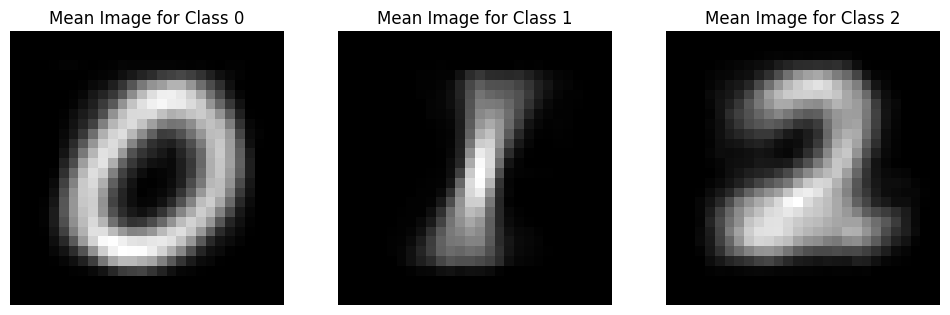

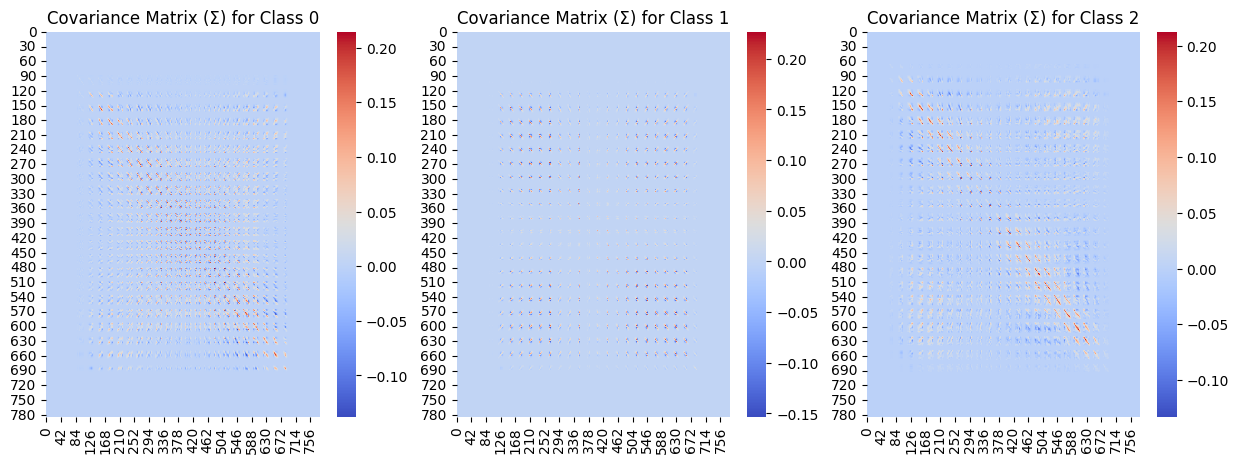

In [53]:
import matplotlib.pyplot as plt
!py -3.13 -m pip install seaborn

import seaborn as sns

# 1️ Plot the Mean Images for each class (0, 1, 2)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for idx, c in enumerate(classes):
    mean_image = means[c].reshape(28, 28)  # Reshape (784,) to (28,28)
    axes[idx].imshow(mean_image, cmap='gray')
    axes[idx].set_title(f"Mean Image for Class {c}")
    axes[idx].axis("off")

plt.show()

# 2️ Plot the Covariance Matrix Heatmap for each class (0, 1, 2)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, c in enumerate(classes):
    sns.heatmap(covariances[c], ax=axes[idx], cmap="coolwarm", cbar=True)
    axes[idx].set_title(f"Covariance Matrix (Σ) for Class {c}")

plt.show()


# *Dimensionality Reduction using PCA [2]*

In [54]:
import numpy as np

# (a) Compute mean vector μ (shape: 784,)
mu = np.mean(train_X, axis=0)

# (b) Center the data: Xc = X - μ
Xc = train_X - mu  # Shape: (300, 784)

# (c) Compute covariance matrix S = (Xc^T * Xc) / (n-1)
S = np.dot(Xc.T, Xc) / (train_X.shape[0] - 1)  # Shape: (784, 784)

# (d) Compute eigenvalues & eigenvectors
eigvals, eigvecs = np.linalg.eigh(S)  # eigh is used because S is symmetric

# (d) Sort eigenvalues & eigenvectors in descending order
sorted_indices = np.argsort(eigvals)[::-1]  # Sort in descending order
eigvals = eigvals[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]  # Columns are principal components

# (e) Select top principal components to retain 95% variance
total_variance = np.sum(eigvals)
explained_variance = np.cumsum(eigvals) / total_variance
num_components_95 = np.argmax(explained_variance >= 0.95) + 1  # Find first component that retains 95%

Up = eigvecs[:, :num_components_95]  # Principal components (shape: 784 × num_components_95)
Y_train = np.dot(Xc, Up)  # Transform train set into PCA space (Y = U_p^T * Xc)
Y_test = np.dot(test_X - mu, Up)  # Project test data using the same transformation

print(f"Original dimension: {train_X.shape[1]}")
print(f"Reduced dimension (95% var): {num_components_95}")
print(f"Shape of Y_train (PCA-transformed data): {Y_train.shape}")
print(f"Shape of Y_test (PCA-transformed test set): {Y_test.shape}")


Original dimension: 784
Reduced dimension (95% var): 82
Shape of Y_train (PCA-transformed data): (300, 82)
Shape of Y_test (PCA-transformed test set): (300, 82)


# ***Verification for PCA by using Comparing with sklearn.PCA***

In [55]:
!py -3.13 -m pip install scikit-learn

from sklearn.decomposition import PCA

pca_sklearn = PCA(n_components=0.95)
pca_sklearn.fit(train_X)

print("Manual PCA reduced dimension:", num_components_95)
print("sklearn PCA reduced dimension:", pca_sklearn.n_components_)


Manual PCA reduced dimension: 82
sklearn PCA reduced dimension: 82



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# ***Class Projection using Fisher’s Discriminant Analysis (FDA)***

In [56]:
#1: Compute FDA Manually (Fix Complex Values)
import numpy as np

# 1️ Compute class means (μ_c) in PCA space
class_means = {}
overall_mean = np.mean(Y_train, axis=0)  # Mean of all data (shape: 83,)

for c in np.unique(train_y):
    class_means[c] = np.mean(Y_train[train_y == c], axis=0)  # Mean per class (shape: 83,)

# 2️ Compute Between-Class Scatter Matrix (SB)
SB = np.zeros((Y_train.shape[1], Y_train.shape[1]))  # Shape: (83,83)

for c in np.unique(train_y):
    Nc = np.sum(train_y == c)  # Number of samples in class c
    mean_diff = (class_means[c] - overall_mean).reshape(-1, 1)  # Column vector (83,1)
    SB += Nc * np.dot(mean_diff, mean_diff.T)  # Outer product (83,83)

# 3️ Compute Within-Class Scatter Matrix (SW)
SW = np.zeros((Y_train.shape[1], Y_train.shape[1]))  # Shape: (83,83)

for c in np.unique(train_y):
    Xc = Y_train[train_y == c]  # Samples of class c
    mean_c = class_means[c]
    SW += np.dot((Xc - mean_c).T, (Xc - mean_c))  # Scatter matrix per class

# 4️ Solve Generalized Eigenvalue Problem: SW^-1 SB using `eigh()` to get real values
eigvals, eigvecs = np.linalg.eigh(np.linalg.inv(SW).dot(SB))

# 5️ Sort eigenvalues & eigenvectors in descending order
sorted_indices = np.argsort(eigvals)[::-1]  # Sort indices based on eigenvalues
eigvals = eigvals[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]  # Columns are eigenvectors

# 6️ Select top 2 eigenvectors (since we have 3 classes)
W_fda = np.real(eigvecs[:, :2])  # Ensure real values

# 7️ Project data onto FDA space
train_X_fda_manual = np.dot(Y_train, W_fda)  # Shape: (300, 2)
test_X_fda_manual  = np.dot(Y_test, W_fda)   # Shape: (300, 2)


print("Shape of manually computed FDA-transformed train set:", train_X_fda_manual.shape)
print("Shape of manually computed FDA-transformed test set:", test_X_fda_manual.shape)


Shape of manually computed FDA-transformed train set: (300, 2)
Shape of manually computed FDA-transformed test set: (300, 2)


# *Results and visualization*

Between-Class Scatter Matrix (S_B):

[[ 2.88412150e+03  3.79386317e+01 -1.44375059e+01 ... -4.68038119e+00
   2.69109007e+00 -1.79501714e-01]
 [ 3.79386317e+01  1.04716765e+03  2.13841642e+02 ... -2.58391617e+00
   5.34614242e-01  2.12158753e+00]
 [-1.44375059e+01  2.13841642e+02  4.38392372e+01 ... -4.92361712e-01
   8.86124060e-02  4.35221386e-01]
 ...
 [-4.68038119e+00 -2.58391617e+00 -4.92361712e-01 ...  1.36739356e-02
  -5.57017719e-03 -4.82717110e-03]
 [ 2.69109007e+00  5.34614242e-01  8.86124060e-02 ... -5.57017719e-03
   2.74908151e-03  8.45542143e-04]
 [-1.79501714e-01  2.12158753e+00  4.35221386e-01 ... -4.82717110e-03
   8.45542143e-04  4.32118775e-03]]


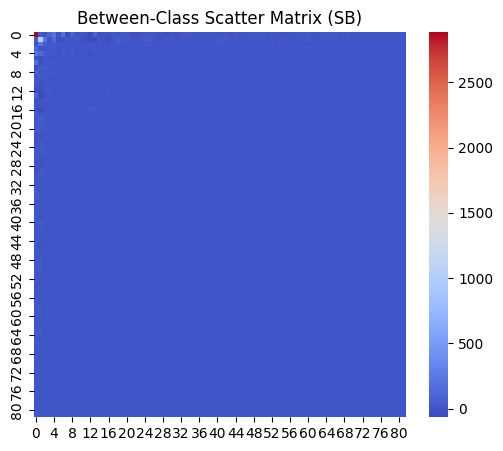

Within-Class Scatter Matrix (S_W):

[[ 6.43200316e+02 -3.79386317e+01  1.44375059e+01 ...  4.68038119e+00
  -2.69109007e+00  1.79501714e-01]
 [-3.79386317e+01  5.94245849e+02 -2.13841642e+02 ...  2.58391617e+00
  -5.34614242e-01 -2.12158753e+00]
 [ 1.44375059e+01 -2.13841642e+02  8.97317934e+02 ...  4.92361712e-01
  -8.86124060e-02 -4.35221386e-01]
 ...
 [ 4.68038119e+00  2.58391617e+00  4.92361712e-01 ...  1.69656791e+01
   5.57017719e-03  4.82717110e-03]
 [-2.69109007e+00 -5.34614242e-01 -8.86124060e-02 ...  5.57017719e-03
   1.65349292e+01 -8.45542143e-04]
 [ 1.79501714e-01 -2.12158753e+00 -4.35221386e-01 ...  4.82717110e-03
  -8.45542143e-04  1.63373657e+01]]


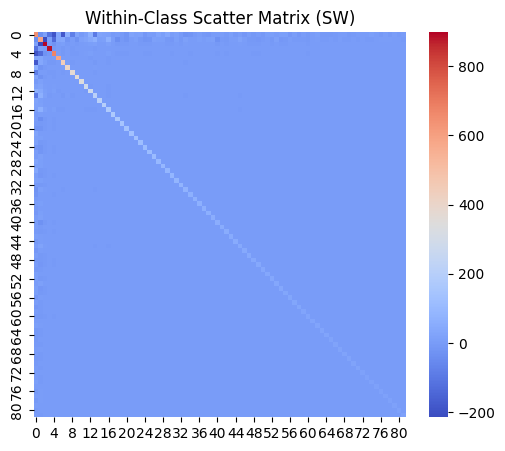

Eigenvalues of FDA (S_W⁻¹ S_B):

[ 4.02905538e+01  1.62199019e+01 -5.53170839e-06 -1.46217069e-05
 -1.90131974e-05 -2.57904739e-05 -2.69309845e-05 -3.50795147e-05
 -4.53072736e-05 -6.42488168e-05 -6.75614106e-05 -9.06410434e-05
 -1.00558467e-04 -1.21698579e-04 -1.25844461e-04 -1.28551560e-04
 -1.46765229e-04 -1.53713721e-04 -1.75981536e-04 -1.81913234e-04
 -1.92929797e-04 -1.94081120e-04 -1.98451750e-04 -2.01546274e-04
 -2.22298719e-04 -2.51269274e-04 -2.53091201e-04 -2.95818296e-04
 -3.37174816e-04 -3.48105541e-04 -3.70778994e-04 -3.74157139e-04
 -4.11249318e-04 -4.40007873e-04 -4.52617809e-04 -5.02171893e-04
 -5.11095122e-04 -5.30037604e-04 -5.52547203e-04 -5.59801529e-04
 -6.63904754e-04 -6.95902721e-04 -7.57033554e-04 -8.07517617e-04
 -8.97158228e-04 -1.02260258e-03 -1.05843892e-03 -1.26121499e-03
 -1.26228288e-03 -1.53588451e-03 -1.76069673e-03 -1.90399720e-03
 -1.92802644e-03 -2.18171568e-03 -2.55798182e-03 -2.58968503e-03
 -2.74063378e-03 -2.80489499e-03 -3.42891155e-03 -3.99522

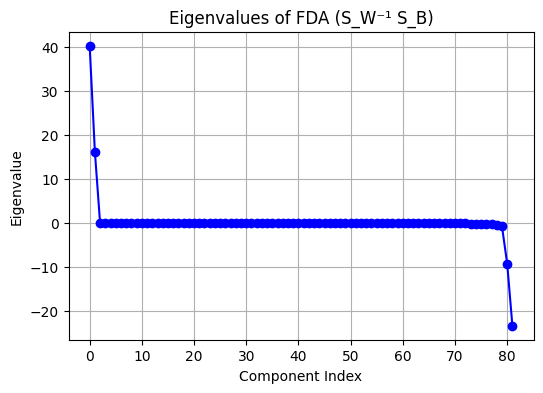

Top 2 Eigenvectors (FDA Projection Matrix W_fda):

[[-7.54087864e-01  1.00943768e-01]
 [-1.10950996e-01 -7.17010485e-01]
 [-1.91449263e-02 -1.80291144e-01]
 [-5.65279887e-02  2.05049138e-02]
 [-1.35933472e-01 -1.05749812e-01]
 [ 2.64063406e-02  3.03420989e-02]
 [-1.47604370e-01  7.43992218e-02]
 [ 5.41581943e-02 -3.69712147e-02]
 [-8.25843721e-02  1.65840537e-02]
 [ 1.55499843e-02 -4.11423099e-02]
 [ 4.51605002e-05  2.06720897e-02]
 [ 2.71349290e-02  3.53082208e-02]
 [ 9.87519224e-02  6.10544788e-02]
 [-1.30803116e-01  1.67221257e-01]
 [ 3.88661568e-02  1.24248571e-02]
 [ 3.91889592e-02  2.32990032e-02]
 [ 5.54411495e-02  1.55762258e-01]
 [-4.45510758e-03  1.94508585e-02]
 [-1.36770011e-02 -1.07694556e-01]
 [-1.42808526e-02 -1.96289799e-02]
 [-6.48633297e-02 -4.85750768e-02]
 [ 5.83529228e-02 -2.31555042e-03]
 [ 3.92269060e-02  3.25391443e-02]
 [ 4.82562049e-02 -4.23361669e-02]
 [-5.23961276e-02 -6.25637446e-02]
 [-1.32604124e-03 -6.54249042e-02]
 [ 1.78766656e-02  4.46586056e-02]
 [ 9

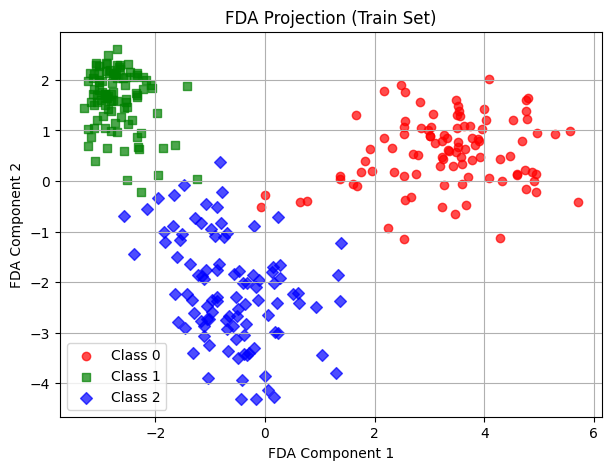

In [57]:
print("Between-Class Scatter Matrix (S_B):\n")
print(SB)  # Print raw computed S_B

# Visualizing S_B as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(SB, cmap="coolwarm", cbar=True)
plt.title("Between-Class Scatter Matrix (SB)")
plt.show()

print("Within-Class Scatter Matrix (S_W):\n")
print(SW)  # Print raw computed S_W

# Visualizing S_W as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(SW, cmap="coolwarm", cbar=True)
plt.title("Within-Class Scatter Matrix (SW)")
plt.show()

print("Eigenvalues of FDA (S_W⁻¹ S_B):\n")
print(eigvals)  # Print raw eigenvalues

# Plot eigenvalues to see their importance
plt.figure(figsize=(6,4))
plt.plot(eigvals, marker='o', linestyle='-', color='b')
plt.xlabel("Component Index")
plt.ylabel("Eigenvalue")
plt.title("Eigenvalues of FDA (S_W⁻¹ S_B)")
plt.grid()
plt.show()

print("Top 2 Eigenvectors (FDA Projection Matrix W_fda):\n")
print(W_fda)  # Print raw eigenvectors

print("First 5 samples in FDA-transformed train set:\n")
print(train_X_fda_manual[:5])  # Print first 5 transformed samples

plt.figure(figsize=(7,5))

colors = ['red', 'green', 'blue']
markers= ['o', 's', 'D']
labels_3= [0,1,2]

for c, col, m in zip(labels_3, colors, markers):
    idx = (train_y == c)
    plt.scatter(train_X_fda_manual[idx,0], train_X_fda_manual[idx,1],
                color=col, marker=m, label=f'Class {c}', alpha=0.7)

plt.title("FDA Projection (Train Set)")
plt.xlabel("FDA Component 1")
plt.ylabel("FDA Component 2")
plt.legend()
plt.grid(True)
plt.show()




# ***5: Evaluate and Compare Performance***

In [58]:
import numpy as np

# 1️ Compute class means
class_labels = np.unique(train_y)
class_means = {c: np.mean(train_X_fda_manual[train_y == c], axis=0) for c in class_labels}

# 2️ Compute shared covariance matrix (Σ)
Sw = np.zeros((train_X_fda_manual.shape[1], train_X_fda_manual.shape[1]))
for c in class_labels:
    Xc = train_X_fda_manual[train_y == c]  # Samples of class c
    Sw += np.dot((Xc - class_means[c]).T, (Xc - class_means[c]))

Sw /= len(train_y)  # Normalize by total samples

# 3️ Compute inverse covariance matrix Σ⁻¹
Sw_inv = np.linalg.inv(Sw)

# 4️ Compute class priors
class_priors = {c: np.sum(train_y == c) / len(train_y) for c in class_labels}

# 5️ Compute discriminant function δc(x) and make predictions
def lda_predict(X):
    predictions = []
    for x in X:
        discriminants = {
            c: np.dot(x.T, Sw_inv @ class_means[c]) - 0.5 * np.dot(class_means[c].T, Sw_inv @ class_means[c]) + np.log(class_priors[c])
            for c in class_labels
        }
        predictions.append(max(discriminants, key=discriminants.get))
    return np.array(predictions)

# Predict labels
train_lda_preds = lda_predict(train_X_fda_manual)
test_lda_preds = lda_predict(test_X_fda_manual)

# Compute accuracy
train_lda_acc = np.mean(train_lda_preds == train_y)
test_lda_acc = np.mean(test_lda_preds == test_y)

print(f"LDA on FDA - Train Accuracy: {train_lda_acc:.4f}, Test Accuracy: {test_lda_acc:.4f}")

#QDA
# 1️ Compute class-specific covariance matrices Σ_c
class_covariances = {c: np.cov(train_X_fda_manual[train_y == c].T, bias=True) for c in class_labels}

# 2️ Compute discriminant function δc(x) for QDA
def qda_predict(X):
    predictions = []
    for x in X:
        discriminants = {}
        for c in class_labels:
            cov_c_inv = np.linalg.inv(class_covariances[c])
            cov_c_det = np.linalg.det(class_covariances[c])

            # Compute QDA discriminant function
            discriminants[c] = (-0.5 * np.log(cov_c_det)
                                - 0.5 * np.dot((x - class_means[c]).T, cov_c_inv @ (x - class_means[c]))
                                + np.log(class_priors[c]))
        predictions.append(max(discriminants, key=discriminants.get))
    return np.array(predictions)

# Predict labels
train_qda_preds = qda_predict(train_X_fda_manual)
test_qda_preds = qda_predict(test_X_fda_manual)

# Compute accuracy
train_qda_acc = np.mean(train_qda_preds == train_y)
test_qda_acc = np.mean(test_qda_preds == test_y)

print(f"QDA on FDA - Train Accuracy: {train_qda_acc:.4f}, Test Accuracy: {test_qda_acc:.4f}")


LDA on FDA - Train Accuracy: 0.9767, Test Accuracy: 0.9367
QDA on FDA - Train Accuracy: 0.9833, Test Accuracy: 0.9567


In [59]:
#PCA Implementation
import numpy as np

# 1️ Compute mean vector and center data
mean_vector = np.mean(train_X, axis=0)
X_centered = train_X - mean_vector  # Mean centered data

# 2️ Compute covariance matrix
cov_matrix = np.dot(X_centered.T, X_centered) / (train_X.shape[0] - 1)

# 3️ Compute eigenvalues & eigenvectors
eigvals, eigvecs = np.linalg.eigh(cov_matrix)

# 4️ Sort eigenvalues & eigenvectors in descending order
sorted_indices = np.argsort(eigvals)[::-1]
eigvals = eigvals[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]

# 5️ Compute cumulative variance to select principal components
explained_variance_ratio = np.cumsum(eigvals) / np.sum(eigvals)
num_components = np.argmax(explained_variance_ratio >= 0.95) + 1  # Retain 95% variance

# 6️ Select top eigenvectors
U_p = eigvecs[:, :num_components]

# 7️ Project train & test data onto principal components
train_X_pca_95 = np.dot(X_centered, U_p)  # Shape: (300, ?)
test_X_pca_95 = np.dot(test_X - mean_vector, U_p)  # Center test data before projection

print(f"PCA applied. Reduced dimension: {num_components}")

#LDA Implementation
# 1️ Compute class means
class_labels = np.unique(train_y)
class_means = {c: np.mean(train_X_pca_95[train_y == c], axis=0) for c in class_labels}

# 2️ Compute shared covariance matrix (S_W)
S_W = np.zeros((train_X_pca_95.shape[1], train_X_pca_95.shape[1]))
for c in class_labels:
    Xc = train_X_pca_95[train_y == c]
    S_W += np.dot((Xc - class_means[c]).T, (Xc - class_means[c]))

S_W /= len(train_y)

# 3️ Compute inverse covariance matrix S_W⁻¹
S_W_inv = np.linalg.inv(S_W)

# 4️ Compute class priors
class_priors = {c: np.sum(train_y == c) / len(train_y) for c in class_labels}

# 5️ Compute discriminant function δc(x) and make predictions
def lda_predict(X):
    predictions = []
    for x in X:
        discriminants = {
            c: np.dot(x.T, S_W_inv @ class_means[c]) - 0.5 * np.dot(class_means[c].T, S_W_inv @ class_means[c]) + np.log(class_priors[c])
            for c in class_labels
        }
        predictions.append(max(discriminants, key=discriminants.get))
    return np.array(predictions)

# Predict labels
train_pca_preds = lda_predict(train_X_pca_95)
test_pca_preds = lda_predict(test_X_pca_95)

# Compute accuracy
train_pca_acc = np.mean(train_pca_preds == train_y)
test_pca_acc = np.mean(test_pca_preds == test_y)

print(f"LDA on PCA (95% var) - Train Accuracy: {train_pca_acc:.4f}, Test Accuracy: {test_pca_acc:.4f}")



PCA applied. Reduced dimension: 82
LDA on PCA (95% var) - Train Accuracy: 0.9967, Test Accuracy: 0.9433


In [60]:
#Compare Accuracy with Different PCA Variants
#(a) PCA with 90% Variance Retention
import numpy as np

# 1️ Compute mean vector and center data
mean_vector = np.mean(train_X, axis=0)
X_centered = train_X - mean_vector  # Mean-centered training data

# 2️ Compute covariance matrix
cov_matrix = np.dot(X_centered.T, X_centered) / (train_X.shape[0] - 1)

# 3️ Compute eigenvalues & eigenvectors
eigvals, eigvecs = np.linalg.eigh(cov_matrix)

# 4️ Sort eigenvalues & eigenvectors in descending order
sorted_indices = np.argsort(eigvals)[::-1]
eigvals = eigvals[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]

# 5️ Compute cumulative variance to select principal components
explained_variance_ratio = np.cumsum(eigvals) / np.sum(eigvals)
num_components = np.argmax(explained_variance_ratio >= 0.90) + 1  # Retain 90% variance

# 6️ Select top eigenvectors
U_p_90 = eigvecs[:, :num_components]

# 7️ Project train & test data onto principal components
train_X_pca_90 = np.dot(X_centered, U_p_90)  # Shape: (300, ?)
test_X_pca_90 = np.dot(test_X - mean_vector, U_p_90)  # Center test data before projection

print(f"PCA applied. Reduced dimension (90% variance): {num_components}")

# 1️ Compute class means
class_labels = np.unique(train_y)
class_means = {c: np.mean(train_X_pca_90[train_y == c], axis=0) for c in class_labels}

# 2️ Compute shared covariance matrix (S_W)
S_W_90 = np.zeros((train_X_pca_90.shape[1], train_X_pca_90.shape[1]))
for c in class_labels:
    Xc = train_X_pca_90[train_y == c]
    S_W_90 += np.dot((Xc - class_means[c]).T, (Xc - class_means[c]))

S_W_90 /= len(train_y)

# 3️ Compute inverse covariance matrix S_W⁻¹
S_W_inv_90 = np.linalg.inv(S_W_90)

# 4️ Compute class priors
class_priors = {c: np.sum(train_y == c) / len(train_y) for c in class_labels}

# 5️ Compute discriminant function δc(x) and make predictions
def lda_predict_90(X):
    predictions = []
    for x in X:
        discriminants = {
            c: np.dot(x.T, S_W_inv_90 @ class_means[c]) - 0.5 * np.dot(class_means[c].T, S_W_inv_90 @ class_means[c]) + np.log(class_priors[c])
            for c in class_labels
        }
        predictions.append(max(discriminants, key=discriminants.get))
    return np.array(predictions)

# Predict labels
train_pca_90_preds = lda_predict_90(train_X_pca_90)
test_pca_90_preds = lda_predict_90(test_X_pca_90)

# Compute accuracy
train_pca_90_acc = np.mean(train_pca_90_preds == train_y)
test_pca_90_acc = np.mean(test_pca_90_preds == test_y)

print(f"LDA on PCA (90% var) - Train Accuracy: {train_pca_90_acc:.4f}, Test Accuracy: {test_pca_90_acc:.4f}")



PCA applied. Reduced dimension (90% variance): 51
LDA on PCA (90% var) - Train Accuracy: 0.9933, Test Accuracy: 0.9367


In [61]:
#1: Apply PCA with 2 Components
import numpy as np

# 1️ Compute mean vector and center data
mean_vector = np.mean(train_X, axis=0)
X_centered = train_X - mean_vector  # Mean-centered training data

# 2️ Compute covariance matrix
cov_matrix = np.dot(X_centered.T, X_centered) / (train_X.shape[0] - 1)

# 3️ Compute eigenvalues & eigenvectors
eigvals, eigvecs = np.linalg.eigh(cov_matrix)

# 4️ Sort eigenvalues & eigenvectors in descending order
sorted_indices = np.argsort(eigvals)[::-1]
eigvals = eigvals[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]

# 5️ Select top 2 principal components
U_p_2 = eigvecs[:, :2]

# 6️ Project train & test data onto these 2 components
train_X_pca_2 = np.dot(X_centered, U_p_2)
test_X_pca_2 = np.dot(test_X - mean_vector, U_p_2)  # Center test data before projection

print(f"PCA applied. Reduced dimension: {train_X_pca_2.shape[1]}")


#2: Apply LDA on PCA (2 Components)
# Train LDA on PCA-reduced data (2 components)
# 1️ Compute class means
class_labels = np.unique(train_y)
class_means = {c: np.mean(train_X_pca_2[train_y == c], axis=0) for c in class_labels}

# 2️ Compute shared covariance matrix (S_W)
S_W_2 = np.zeros((train_X_pca_2.shape[1], train_X_pca_2.shape[1]))
for c in class_labels:
    Xc = train_X_pca_2[train_y == c]
    S_W_2 += np.dot((Xc - class_means[c]).T, (Xc - class_means[c]))

S_W_2 /= len(train_y)

# 3️ Compute inverse covariance matrix S_W⁻¹
S_W_inv_2 = np.linalg.inv(S_W_2)

# 4️ Compute class priors
class_priors = {c: np.sum(train_y == c) / len(train_y) for c in class_labels}

# 5️ Compute discriminant function δc(x) and make predictions
def lda_predict_2(X):
    predictions = []
    for x in X:
        discriminants = {
            c: np.dot(x.T, S_W_inv_2 @ class_means[c]) - 0.5 * np.dot(class_means[c].T, S_W_inv_2 @ class_means[c]) + np.log(class_priors[c])
            for c in class_labels
        }
        predictions.append(max(discriminants, key=discriminants.get))
    return np.array(predictions)

# Predict labels
train_pca_2_preds = lda_predict_2(train_X_pca_2)
test_pca_2_preds = lda_predict_2(test_X_pca_2)

# Compute accuracy
train_pca_2_acc = np.mean(train_pca_2_preds == train_y)
test_pca_2_acc = np.mean(test_pca_2_preds == test_y)

print(f"LDA on PCA (2 components) - Train Accuracy: {train_pca_2_acc:.5f}, Test Accuracy: {test_pca_2_acc:.5f}")


PCA applied. Reduced dimension: 2
LDA on PCA (2 components) - Train Accuracy: 0.92000, Test Accuracy: 0.90333


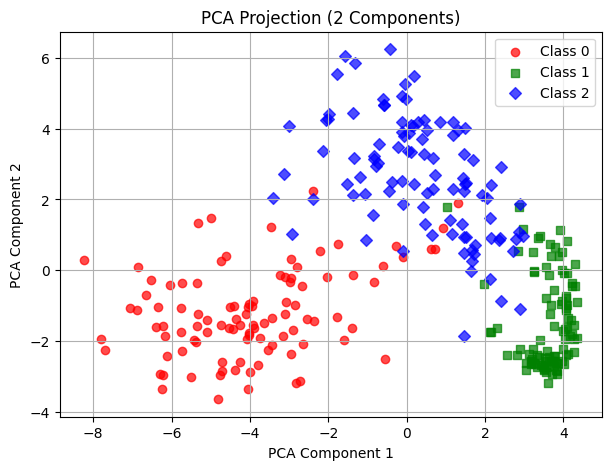

In [62]:
#Verify PCA (2D) Scatter Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

for c, col, m in zip([0,1,2], ['red', 'green', 'blue'], ['o', 's', 'D']):
    idx = (train_y == c)
    plt.scatter(train_X_pca_2[idx,0], train_X_pca_2[idx,1], color=col, marker=m, label=f'Class {c}', alpha=0.7)

plt.title("PCA Projection (2 Components)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


# ***Visualizing FDA vs. PCA (2D) Projections***

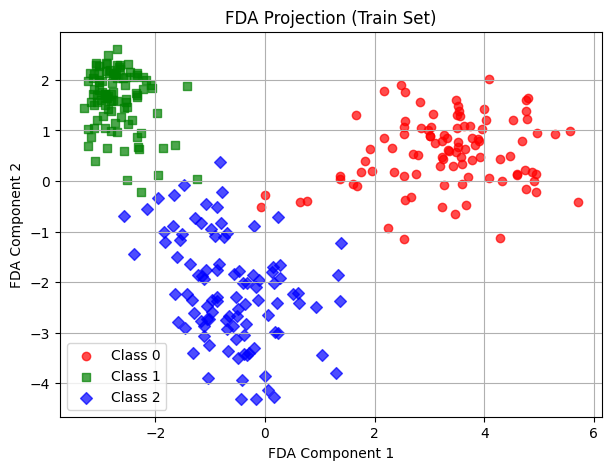

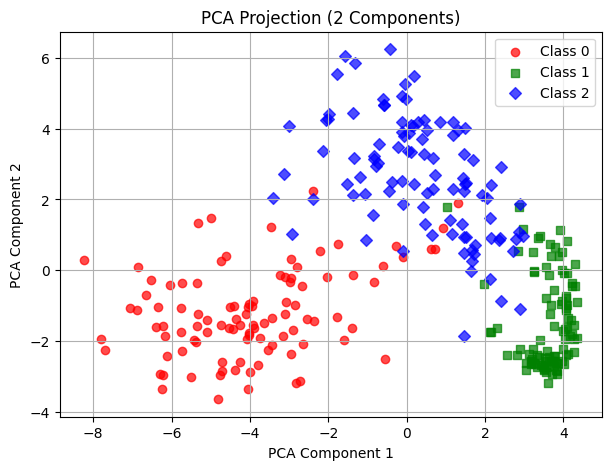

In [63]:
import matplotlib.pyplot as plt

# Plot FDA Projection (2D)
plt.figure(figsize=(7,5))

for c, col, m in zip([0,1,2], ['red', 'green', 'blue'], ['o', 's', 'D']):
    idx = (train_y == c)
    plt.scatter(train_X_fda_manual[idx,0], train_X_fda_manual[idx,1], color=col, marker=m, label=f'Class {c}', alpha=0.7)

plt.title("FDA Projection (Train Set)")
plt.xlabel("FDA Component 1")
plt.ylabel("FDA Component 2")
plt.legend()
plt.grid(True)
plt.show()

# Plot PCA (2 Components) Projection
plt.figure(figsize=(7,5))

for c, col, m in zip([0,1,2], ['red', 'green', 'blue'], ['o', 's', 'D']):
    idx = (train_y == c)
    plt.scatter(train_X_pca_2[idx,0], train_X_pca_2[idx,1], color=col, marker=m, label=f'Class {c}', alpha=0.7)

plt.title("PCA Projection (2 Components)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


# **confusion matrix **

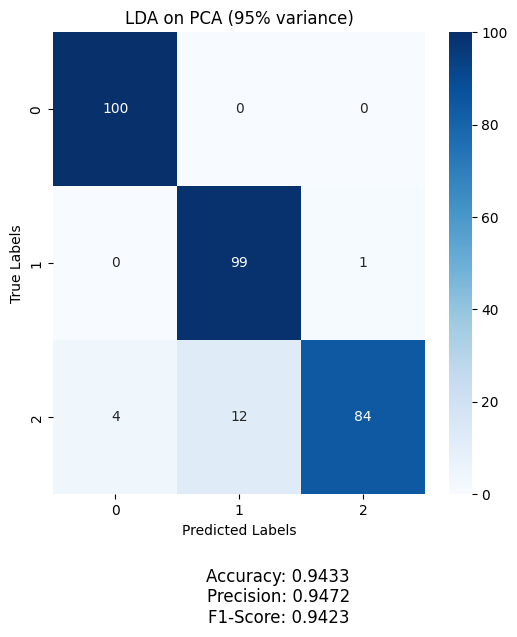

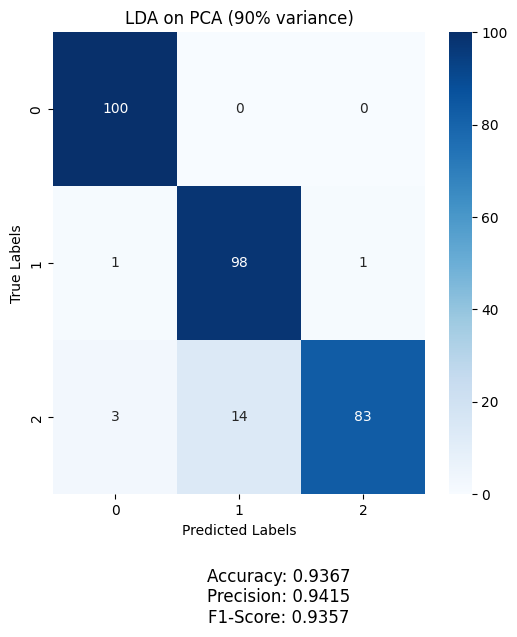

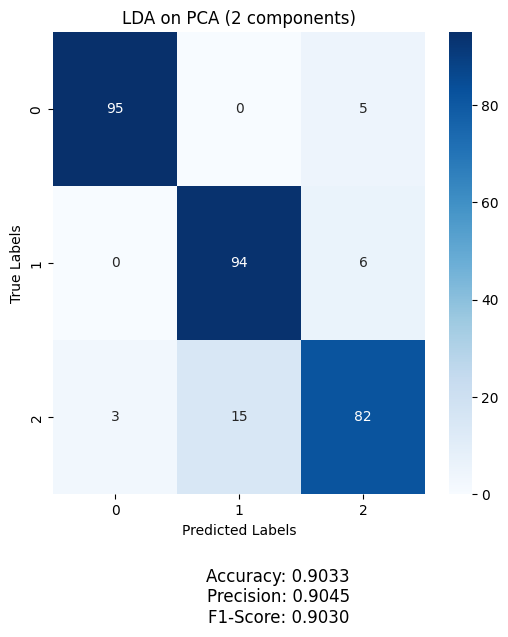

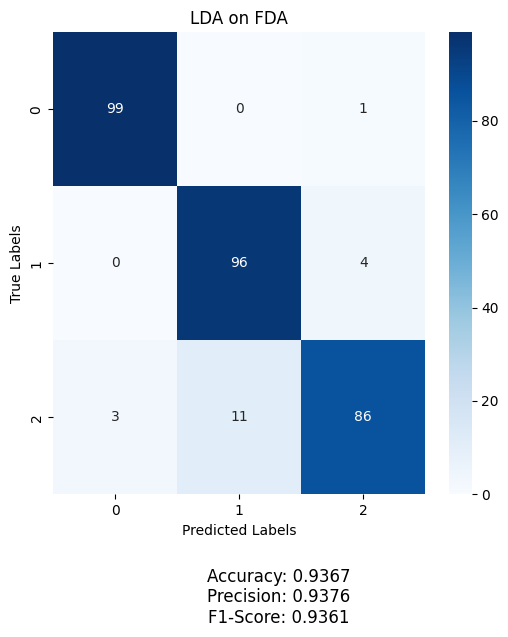

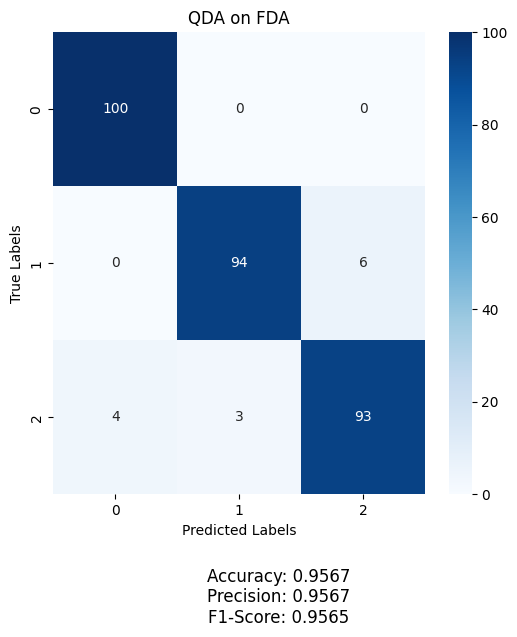

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------- 1. Function to Compute Confusion Matrix -------------------- #
def compute_confusion_matrix(y_true, y_pred, classes=[0, 1, 2]):
    """Computes a confusion matrix from true and predicted labels."""
    num_classes = len(classes)
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for true_label, pred_label in zip(y_true, y_pred):
        true_idx = classes.index(true_label)
        pred_idx = classes.index(pred_label)
        conf_matrix[true_idx, pred_idx] += 1

    return conf_matrix

# -------------------- 2. Compute Metrics (Accuracy, Precision, F1-Score) Manually -------------------- #
def compute_metrics(conf_matrix):
    """Computes Accuracy, Precision, and F1-Score manually."""

    num_classes = conf_matrix.shape[0]

    # Compute accuracy
    total_correct = np.trace(conf_matrix)  # Sum of diagonal elements (correct predictions)
    total_samples = np.sum(conf_matrix)    # Total number of samples
    accuracy = total_correct / total_samples if total_samples != 0 else 0

    # Compute precision and F1-score per class
    precision_per_class = []
    f1_per_class = []

    for c in range(num_classes):
        tp = conf_matrix[c, c]  # True Positives
        fp = np.sum(conf_matrix[:, c]) - tp  # False Positives
        fn = np.sum(conf_matrix[c, :]) - tp  # False Negatives

        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        recall = tp / (tp + fn) if (tp + fn) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        precision_per_class.append(precision)
        f1_per_class.append(f1)

    # Compute weighted average precision & F1-score
    precision = np.mean(precision_per_class)  # Weighted average precision
    f1_score = np.mean(f1_per_class)  # Weighted average F1-score

    return accuracy, precision, f1_score

# -------------------- 3. Compute Confusion Matrices & Metrics -------------------- #
models = {
    "LDA on PCA (95% variance)": test_pca_preds,
    "LDA on PCA (90% variance)": test_pca_90_preds,
    "LDA on PCA (2 components)": test_pca_2_preds,
    "LDA on FDA": test_lda_preds,
    "QDA on FDA": test_qda_preds
}

conf_matrices = {}
metrics = {}

for model_name, predictions in models.items():
    conf_matrices[model_name] = compute_confusion_matrix(test_y, predictions)
    metrics[model_name] = compute_metrics(conf_matrices[model_name])

# -------------------- 4. Function to Plot Confusion Matrix -------------------- #
def plot_confusion_matrix(conf_matrix, title, accuracy, precision, f1):
    """Plots a heatmap for the confusion matrix with accuracy, precision, and F1-score below it."""
    fig, ax = plt.subplots(figsize=(6,6))

    # Plot confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)

    # Display metrics
    metrics_text = f"Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nF1-Score: {f1:.4f}"
    plt.figtext(0.5, -0.1, metrics_text, wrap=True, horizontalalignment='center', fontsize=12)

    plt.show()

# -------------------- 5. Visualizing Confusion Matrices with Metrics -------------------- #
for model_name in models.keys():
    plot_confusion_matrix(
        conf_matrices[model_name],
        model_name,
        *metrics[model_name]  # Unpacks accuracy, precision, F1-score
    )
